In [81]:
%load_ext autoreload
%autoreload 1
%aimport modules.dataset_auxiliary, modules.classification_auxiliary, modules.ml_auxiliary, modules.tensor_module, modules.bullets, modules.clustering_auxiliary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import os
import pickle
import modules.dataset_auxiliary as daux
from modules.dataset_auxiliary import *
from modules.classification_auxiliary import *
from modules.ml_auxiliary import *
from modules.tensor_module import *
from modules.bullets import *
from modules.clustering_auxiliary import *
import copy

# Tensors
import tntorch as tn
import tensorly as tl
from tensorly import random
from tensorly.decomposition import tucker, parafac, partial_tucker
from tensorly.tenalg import mode_dot, multi_mode_dot


# ML
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

import xgboost as xgb
import pystmm


## Load initial ds_dict

In [3]:
# current version
file_path = r'backup/ds_dict.pkl'

# # save:
# with open(file_path, 'wb') as f:
#     pickle.dump(ds_dict, f)

# load:
with open(file_path, 'rb') as f:
    ds_dict = pickle.load(f)

check_ds_dict(ds_dict)
print()

True 	Info: 7468;   Skeleton: 7468;   Total: 7468



In [4]:
df = ds_dict['G101__trial1__left__call']['skeleton']
df.head(5)

,pose__0__x,pose__0__y,pose__0__z,pose__1__x,pose__1__y,pose__1__z,pose__2__x,pose__2__y,pose__2__z,pose__3__x,...,right_hand__17__z,right_hand__18__x,right_hand__18__y,right_hand__18__z,right_hand__19__x,right_hand__19__y,right_hand__19__z,right_hand__20__x,right_hand__20__y,right_hand__20__z
0,0.504566,0.483007,-0.419187,0.512195,0.468248,-0.393816,0.517451,0.468759,-0.394230,0.523402,...,0.001779,0.419982,0.874274,0.001036,0.426798,0.878431,0.001724,0.431595,0.878332,0.002642
1,0.505714,0.482927,-0.419194,0.512769,0.468184,-0.393802,0.518419,0.468713,-0.394216,0.524386,...,0.001621,0.420453,0.875529,0.001330,0.427345,0.879538,0.002506,0.432357,0.879545,0.003786
2,0.506588,0.482852,-0.431591,0.513260,0.468151,-0.406269,0.519245,0.468693,-0.406685,0.525111,...,0.001963,0.419988,0.874982,0.001869,0.426918,0.879153,0.003044,0.432110,0.879536,0.004282
3,0.507106,0.482764,-0.430026,0.513574,0.468106,-0.404846,0.519717,0.468653,-0.405261,0.525549,...,0.002475,0.419770,0.874797,0.002538,0.426700,0.878337,0.003782,0.431636,0.878009,0.005091
4,0.507399,0.482719,-0.437200,0.513772,0.468082,-0.412200,0.519957,0.468635,-0.412618,0.525805,...,0.002163,0.419992,0.875094,0.002145,0.426787,0.878402,0.003366,0.431563,0.877772,0.004613


## Selecting 

In [5]:
gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']
# gestures += ['scroll_up', 'scroll_down', 'swipe_right', 'swipe_left', 'export'] 
# gestures += ['screenshot', 'writing', 'delete']
# gestures += ['moving_down', 'moving_left', 'moving_right', 'moving_up', 'moving_back', 'moving_forward']
# gestures += ['anticlockwise', 'clockwise', 'right_forward', 'left_forward']
# gestures += ['zoom_in_c', 'zoom_out_c', 'zoom_out_l', 'zoom_out_r', 'zoom_in_l',  'zoom_in_r']
# gestures += ['yes_head', 'no_head']

In [6]:
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[0:16], test: subs[16:]"
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5]"
exp_cofig = "one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5]"

# exp_cofig = "all gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"
# exp_cofig = "all gestures  | [x, y] | fill_na: {'value':0} | train: subs[:], test: subs[:5]"

Selected  2812 samples. 4656(7468) was dropped!
14 samples was unvalid. Remain 2798(2812)


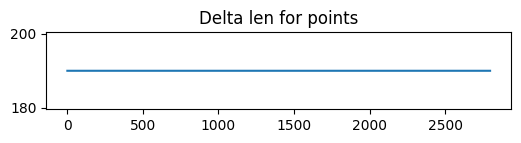

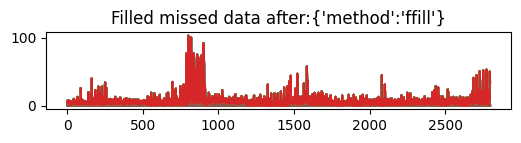

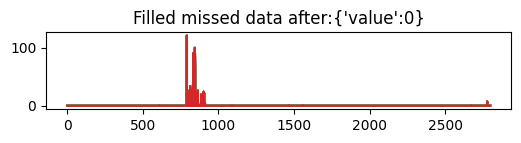

In [210]:
# preparing

subs = get_all_subs_from_ds_dict(ds_dict)
subs = subs[:]
# gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']


data_dict_selected = select_g_ids(ds_dict, subs=subs, gestures=gestures)
data_dict_valid =  select_valid_samples(data_dict_selected)

# points
# data_dict_points = select_points(data_dict_valid, coords=['x', 'y', 'z'], hand_points='def')
data_dict_points = select_points(data_dict_valid, coords=['x', 'y'], hand_points='def')
# data_dict_points = select_points(data_dict_valid, coords=['x', 'y'], pose_points=[12, 14, 16, 11, 13, 15, 0, 5, 2],
                                #  hand_points=[0, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17, 19, 20])
plt.show()

# nan
# data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'value':0})
data_dict_filled_ = update_skeleton(data_dict_points, update_df_fill_na, {'method':'ffill'})
plt.title(f"Filled missed data after:{{'method':'ffill'}}")
plt.show()

data_dict_filled = update_skeleton(data_dict_filled_, update_df_fill_na, {'value':0})
# data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'method':'ffill'})
plt.title(f"Filled missed data after:{{'value':0}}")
plt.show()

# # data_dict_filled = data_dict_points




In [211]:
# cropping
data_dict_adjusted = data_dict_filled
data_dict_adjusted = update_skeleton(data_dict_adjusted, update_df_crop_time, show=False)

# additional preprocessing
# data_dict_adjusted = update_skeleton(data_dict_adjusted, update_df_to_speed, show=True)
# data_dict_adjusted = update_skeleton(data_dict_adjusted, update_df_to_coord_and_speed, show=True)





#train
print('Train')
data_dict = select_g_ids(data_dict_adjusted, subs=subs[:])
data_dict, label_dict = form_gesture_labels(data_dict)
samples_list,  labels_list, sub_list = form_samples_labels_lists(data_dict, return_subjects=True)
data_tensor = np.concatenate(samples_list, axis=0)

#test 
print('Test')
data_dict_test = select_g_ids(data_dict_adjusted, subs=subs[:5])
# data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
data_dict_test, label_dict_test = form_gesture_labels(data_dict_test, label_dict=label_dict)
samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
data_tensor_test = np.concatenate(samples_list_test, axis=0)


Train
Selected  2798 samples. 0(2798) was dropped!
Test
Selected  657 samples. 2141(2798) was dropped!


### To matlab


In [26]:
import scipy

In [27]:
def save_pickle(path, data):
    with open(path, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL) 
        
def save_mat(path, data, k_form_fun=None, verbose=1):
    if not isinstance(data, dict):
        key = k_form_fun(path) if k_form_fun is not None else 'data'
        data = {key: data}
        if verbose > 0:
            print(f"Warning, data was worped into dict: {{{key}: data}}")
    # mat4py.savemat(path, data)
    scipy.io.savemat(path, data)


In [50]:
data = {'labels': labels_list,
        # 'label_dict': label_dict,
        'data': data_tensor_}

In [51]:
# path = 'gestures_4d_full'
path = 'gestures_4d_one_hand'
data = data
save_pickle(path + '.pkl', data)
save_mat(path + '.mat',data)

## Tensor preprocessing

In [9]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


### CPD

In [34]:
# CPD  - bad
t = data_tensor
tt = data_tensor_test
rank = 20
factors_CPD = parafac(t, rank=rank)


In [11]:
# CPD - bad
t = data_tensor
tt = data_tensor_test
rank = 4
factors_CPD = parafac(t, rank=rank)

In [13]:
# t_cuda = torch.from_numpy(t)
# t_cuda = t_cuda.to('cuda')
# factors_CPD_cuda = parafac(t, rank=rank)

In [14]:
t_rec_CPD = tl.cp_to_tensor(factors_CPD)
print(f"CPD: Rank: {rank: }, distance: {tl.norm(t - t_rec_CPD)} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_CPD)}")

CPD: Rank:  4, distance: 276.8923469930958 ; norm origin: 4284.077285366963 ; norm recovered: 4275.119742787772


In [15]:
U = factors_CPD.factors[0]
U.shape

(2798, 4)

In [23]:
# Clustering:
X = U

kmeans = KMeans(n_clusters=22, random_state=0, n_init=5)
kmeans.fit(X)

KMeans(n_clusters=22, n_init=5, random_state=0)

In [26]:
# rank = 8
normalized_mutual_info_score(kmeans.labels_,labels_list)

0.399466475412532

In [25]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2798 samples in 0.003s...
[t-SNE] Computed neighbors for 2798 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2798
[t-SNE] Computed conditional probabilities for sample 2000 / 2798
[t-SNE] Computed conditional probabilities for sample 2798 / 2798
[t-SNE] Mean sigma: 0.382193
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.183441
[t-SNE] KL divergence after 1000 iterations: 0.719955


Text(0.5, 0.98, 'CPD, rank 20, normalized_mutual_info_score= 39.95%')

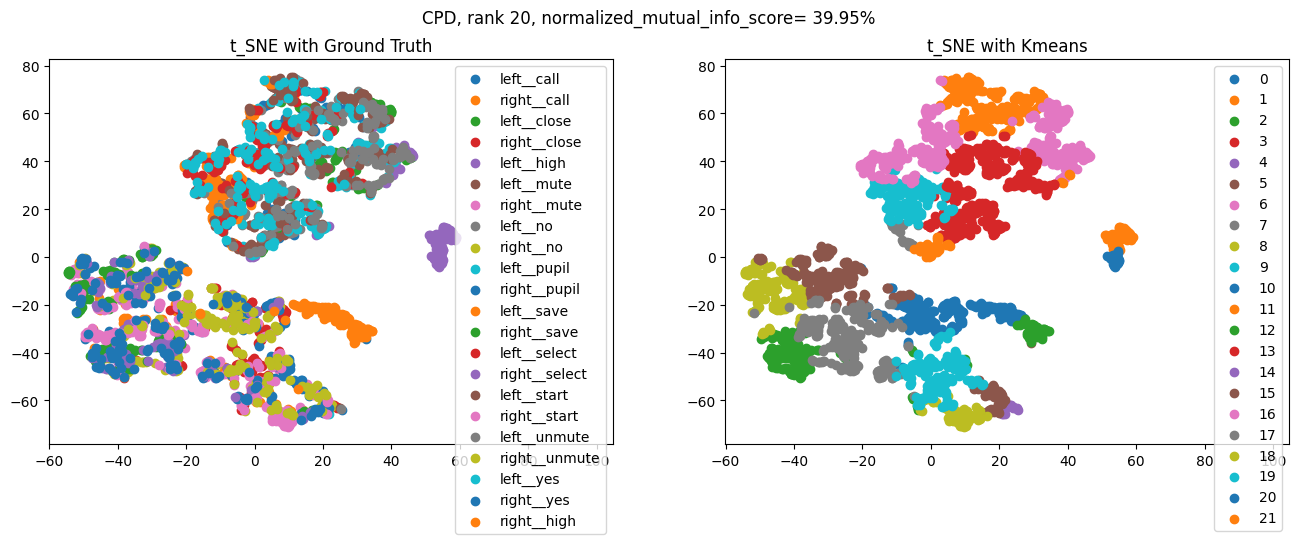

In [29]:

# plt.figure(figsize=[8, 5])
labels_order = [labels_list, kmeans.labels_]
fig, axs = plt.subplots(1, 2, figsize=[16, 5])

for j, (ax, labels) in enumerate(zip(axs, labels_order)):
    for i in range(len(label_dict)):
        mask = np.where(np.array(labels) == i)
        if j == 0:
            legend_label = f'{label_dict[i]}'
            title = "t_SNE with Ground Truth" 
        elif j == 1:
            legend_label = str(i)
            title = "t_SNE with Kmeans" 
            
        ax.scatter(z[mask,0], z[mask, 1], label=legend_label)
    ax.set_title(title)  
    ax.legend()
    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0], xlim[1]+40)


acc = normalized_mutual_info_score(kmeans.labels_,labels_list)
plt.gcf().suptitle(f'CPD, rank 20, normalized_mutual_info_score={acc*100: .2f}%')



KMeans(n_clusters=22, random_state=0)

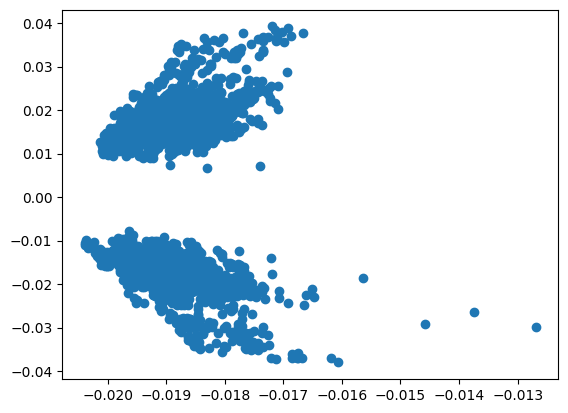

In [72]:
plt.scatter(X[:,0], X[:, 1])

In [19]:

# factors = factors_CPD
# # core = gen_diag_core_tensor(rank,len(factors.factors), factors.weights)
# # tensor = mode_dot(core_t, factors.factors[0], mode=0)

# tensor_CPD = multi_mode_dot(t, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])
# tensor_CPD_test = multi_mode_dot(tt, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])

### PCA

In [103]:
matrix_PCA, matrix_PCA_test = get_PCA_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2)

PCA tranformation with rank: 2152. tensor shape: (2152, 120, 134)
PCA: Rank: 2152, rel_error:  0.00736 ; norm origin: 3721.62545533791 ; norm recovered: 3721.524656272879


#### code

In [94]:
# from sklearn.decomposition import PCA
# X = t_uf0

# pca = PCA(n_components=600, svd_solver='full')
# pca.fit(X)

# matrix_PCA = pca.transform(t_uf0)
# matrix_PCA_test =  pca.transform(tt_uf0)


PCA(n_components=600, svd_solver='full')

In [ ]:
# norm_t = tl.norm(t)
# t_rec = pca.inverse_transform(matrix_PCA)
# print(f"PCA: N Components: {rank }, rel_error: {tl.norm(t_uf0 - t_rec)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec)}")
         

In [106]:
# def get_PCA_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2):
#     t = data_tensor
#     tt = data_tensor_test

#     t_uf0 = tl.unfold(t, mode=0)
#     tt_uf0 = tl.unfold(tt, mode=0)
    
#     if rank is None or rank == -1:
#         rank = np.min(t_uf0.shape)
        
#     pca = PCA(n_components=rank, svd_solver='full')
#     pca.fit(X)
        
#     if verbose > 1:
#         print(f"PCA tranformation with rank: {rank}. tensor shape: {data_tensor.shape}")

#     matrix_PCA = pca.transform(t_uf0)
    
#     if verbose > 0:
#         norm_t = tl.norm(t)
#         t_rec = pca.inverse_transform(matrix_PCA)
#         print(f"PCA: Rank: {rank }, rel_error: {tl.norm(t_uf0 - t_rec)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec)}")
           
            
#     matrix_PCA = matrix_PCA
#     matrix_PCA_test =  pca.transform(tt_uf0)
#     return matrix_PCA, matrix_PCA_test

### SVD

In [104]:
matrix_SVD, matrix_SVD_test = get_SVD_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2)

SVD decomposition with rank: 2152. tensor shape: (2152, 120, 134)
SVD: Rank: 2152, rel_error:  0.00000 ; norm origin: 3721.62545533791 ; norm recovered: 3721.6254553379113


#### code

In [83]:
# t = data_tensor
# tt = data_tensor_test

# t_uf0 = tl.unfold(t, mode=0)
# tt_uf0 = tl.unfold(tt, mode=0)

# u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
# norm_t = tl.norm(t)

# rank = 600
# # rank = 5688



In [84]:
# rank = 600

In [85]:
# t_rec_SVD = recover_svd((u_0, s_0, v_0), rank=rank)
# print(f"SVD: Rank: {rank }, rel_error: {tl.norm(t_uf0 - t_rec_SVD)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec_SVD)}")

SVD: Rank: 600, rel_error:  0.00304 ; norm origin: 699.5597166036002 ; norm recovered: 699.468366558339


In [98]:
# matrix_SVD = np.matmul(t_uf0, v_0[:rank, :].T)
# matrix_SVD_test = np.matmul(tt_uf0, v_0[:rank, :].T)

In [93]:
# def get_SVD_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2):
#     t = data_tensor
#     tt = data_tensor_test

#     t_uf0 = tl.unfold(t, mode=0)
#     tt_uf0 = tl.unfold(tt, mode=0)
    
#     u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
    
#     if rank is None or rank == -1:
#         rank = len(s_0)
        
#     if verbose > 1:
#         print(f"Decomposition with rank: {rank}. tensor shape: {data_tensor.shape}")

#     if verbose > 0:
#         norm_t = tl.norm(t)
#         t_rec_SVD = recover_svd((u_0, s_0, v_0), rank=rank)
#         print(f"SVD: Rank: {rank }, rel_error: {tl.norm(t_uf0 - t_rec_SVD)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec_SVD)}")
            
#         matrix_SVD = np.matmul(t_uf0, v_0[:rank, :].T)
#         matrix_SVD_test = np.matmul(tt_uf0, v_0[:rank, :].T)
#     return matrix_SVD, matrix_SVD_test

#### Selecting rank

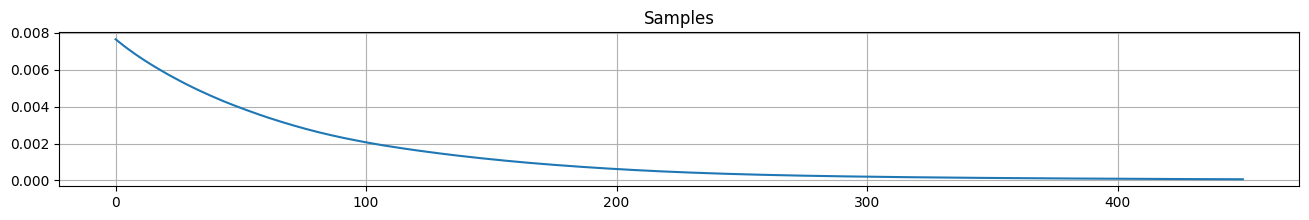

In [28]:
# show_decomposition_error(s_0, norm_t,'Samples',show=False, start=50, end=500)
# # plt.gcf().set_size_inches((16, 2))

### Tucker all

In [10]:
def tucker_decompose(tensor, rank):
    if rank is None or rank == -1:
        rank = tensor.shape
    
    print(f"Tucker decomposition with rank: {rank}. tensor shape: {tensor.shape}")
        
    t_tucker = tn.Tensor(torch.from_numpy(tensor), ranks_tucker=rank)
    core_tucker = t_tucker.tucker_core().numpy()
    factors_tucker = [U.numpy() for U in t_tucker.Us]
    return core_tucker, factors_tucker 

In [197]:
data_tensor_ = data_tensor
labels_list_ = labels_list

(2798, 120, 82)

In [225]:
mask = np.isin(np.array(labels_list), [0, 2])
data_tensor_ = data_tensor[mask]
labels_list_ = np.array(labels_list)[mask]

In [213]:
data_tensor_.shape

(251, 120, 134)

In [214]:

t = data_tensor_ 

# rank = -1
rank = [2798, 120, 134]


if rank is None or rank == -1:
    rank = data_tensor.shape
    
print(f"Tucker decomposition with rank: {rank}. tensor shape: {data_tensor.shape}")
    
modes = [i for i in range(len(data_tensor.shape))]
modes = modes[1:]
t_tucker = tn.Tensor(torch.from_numpy(t), ranks_tucker=rank)
# print(tn.relative_error(torch.Tensor(t), t_tucker))
core_tucker = t_tucker.tucker_core().numpy()
factors_tucker = [U.numpy() for U in t_tucker.Us]

Tucker decomposition with rank: [2798, 120, 134]. tensor shape: (2798, 120, 134)


In [216]:
t = data_tensor_
rank = data_tensor.shape[1:]
core_tucker, factors_tucker = partial_tucker(t, [1, 2], rank=rank, n_iter_max=1000)

In [217]:
core_tucker.shape

(251, 120, 134)

In [17]:
U_t = factors_tucker[0]
U_t.shape


(120, 120)

In [218]:
U_t_core = core_tucker.reshape(core_tucker.shape[0], -1)
U_t_core.shape

(251, 16080)

In [219]:
U_t = U_t_core

In [221]:
# Clustering:
X = U_t

kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(X)

KMeans(n_clusters=2, random_state=0)

In [223]:
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(n_clusters=2)
AC.fit(X)

AgglomerativeClustering()

In [222]:
# TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123, learning_rate='auto', init='pca', n_jobs=32)
z_t = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 251 samples in 0.004s...
[t-SNE] Computed neighbors for 251 samples in 0.213s...
[t-SNE] Computed conditional probabilities for sample 251 / 251
[t-SNE] Mean sigma: 2.502126


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.566380
[t-SNE] KL divergence after 1000 iterations: 0.416625


In [226]:
method = 'geometric'
for method in ['min', 'geometric', 'arithmetic', 'max']:
    acc = normalized_mutual_info_score(AC.labels_,labels_list_, average_method=method)
    print(f"For {method}:", f"{acc*100 :.2f}%")

For min: 21.80%
For geometric: 21.70%
For arithmetic: 21.70%
For max: 21.61%


In [86]:
# def show_2d_representation(repr_2d, labels_list_list, label_dict, legend_space=True, second_subtitle='clustering', repr_name='t-SNE'):
#     labels_order = labels_list_list
#     fig, axs = plt.subplots(1, len(labels_list_list), figsize=[len(labels_list_list)*8, 5])
#     z = repr_2d
#     for j, (ax, labels) in enumerate(zip(axs, labels_order)):
#         for i in range(len(label_dict)):
#             mask = np.where(np.array(labels) == i)
#             mask = mask[0]
#             if mask.size == 0:
#                 continue
#             if j == 0:
#                 legend_label = f'{i}: {label_dict[i]}'
#                 title = f"{repr_name} with Ground Truth" 
#             elif j == 1:
#                 legend_label = str(i)
#                 title = f"{repr_name} with {second_subtitle}" 
#             mean_ = z[mask].mean(axis=0)
#             ax.scatter(z[mask,0], z[mask, 1], label=legend_label)
#             tx = ax.text(mean_[0], mean_[1], f"{i}", ha='center', va='center')
#             # ax1.scatter(C[:,0],C[:,1],c = 'r',marker = 'x')
            
#             # if i % 9 == 0 and i != 0:
#             #     break
#         ax.set_title(title)  
#         ax.legend()
#         if legend_space:
#             xlim = ax.get_xlim()
#             ax.set_xlim(xlim[0], xlim[1]+100)
            
#             # ax.set_xlim(-10, 10)
#             # ax.set_ylim(-10, 10)
    

In [72]:
a = form_label_values(labels_list, label_dict)

2 unique labels were formed
2 unique labels were formed


Text(0.5, 0.98, 'Tucker, rank (120, 134), normalized_mutual_info_score= 21.70%')

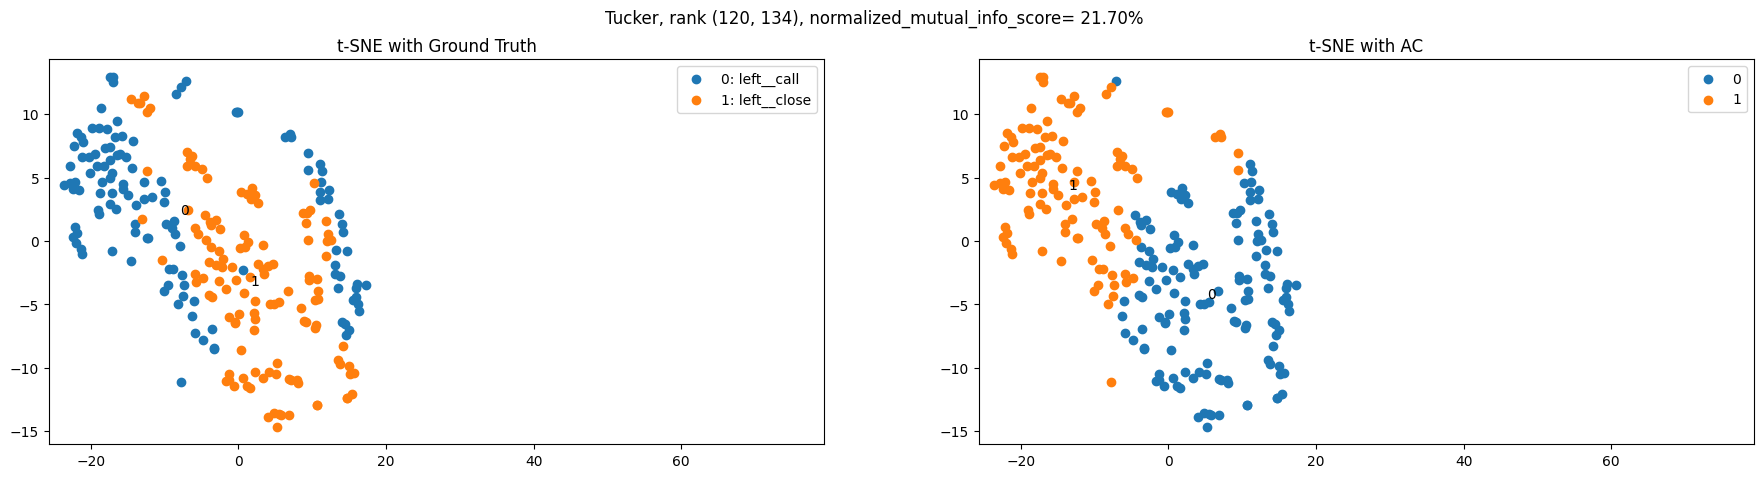

In [230]:
labels_order = [form_label_values(labels_list_, label_dict), AC.labels_]
show_repr_2d(z_t, labels_order, show_nums=True, second_subtitle="AC", legend_space=60)
acc = normalized_mutual_info_score(AC.labels_,labels_list_)
plt.gcf().suptitle(f'Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

Text(0.5, 0.98, 'Tucker, rank [120, 134], normalized_mutual_info_score= 41.77%')

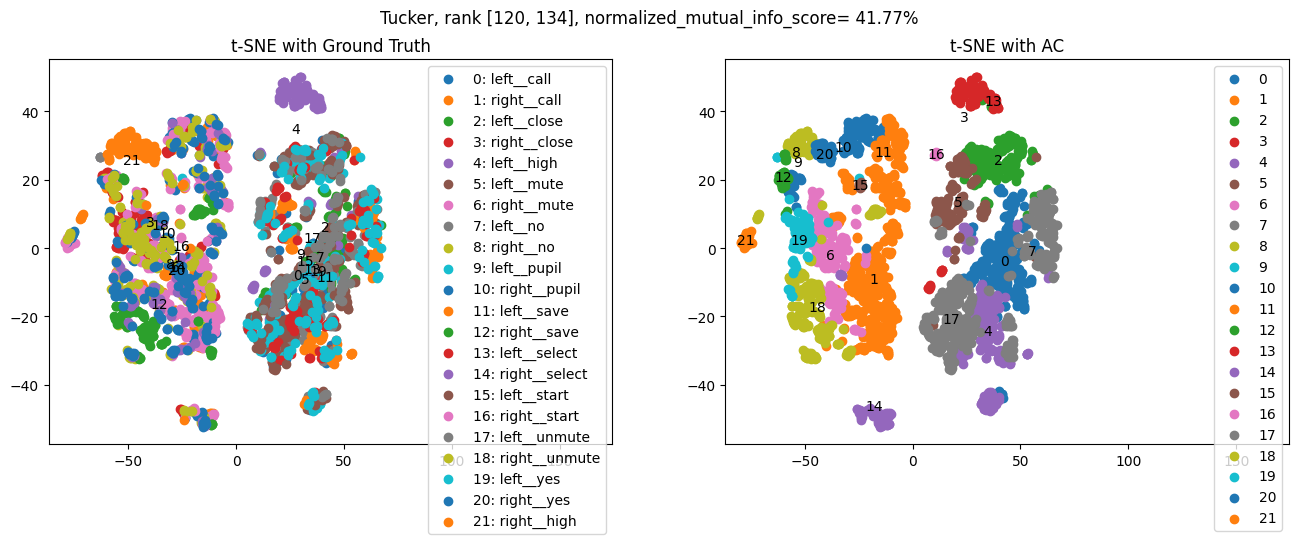

In [33]:
labels_order = [labels_list, AC.labels_]
show_2d_representation(z_t, labels_order, label_dict, second_subtitle='AC') 
acc = normalized_mutual_info_score(AC.labels_,labels_list)
plt.gcf().suptitle(f'Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

In [34]:
# Clustering hands:
X = U_t

kmeans_hands = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_hands.fit(X)

KMeans(n_clusters=2, random_state=0)

In [35]:
left_hand = [0, 2, 4, 5, 7, 9, 11, 13, 15, 17, 19]
len(left_hand)

11

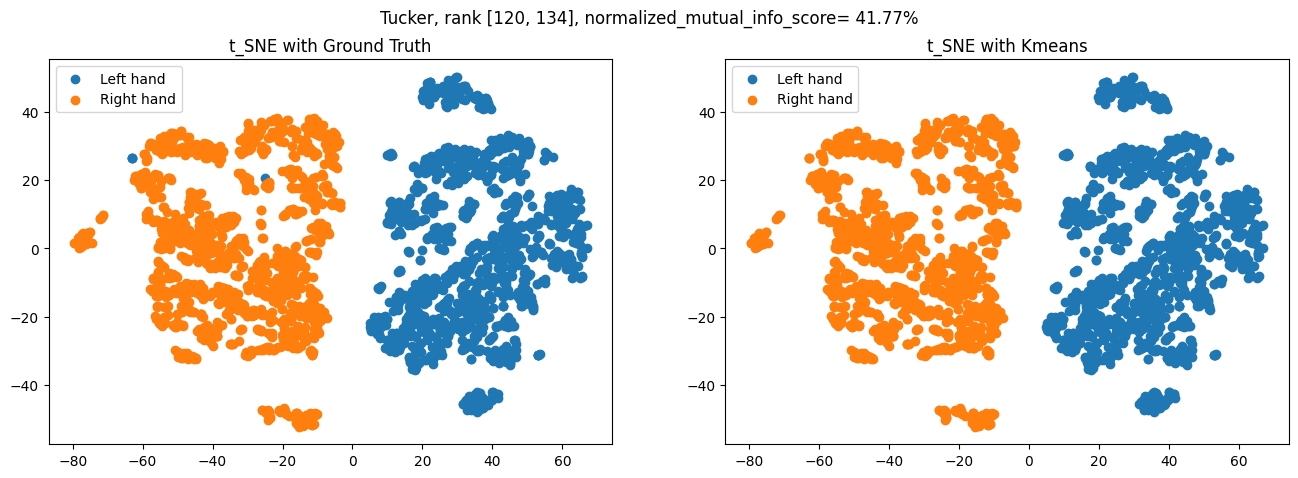

In [36]:
# hands

# plt.figure(figsize=[8, 5])
labels_order = [labels_list, kmeans_hands.labels_]
fig, axs = plt.subplots(1, 2, figsize=[16, 5])
plt.gcf().suptitle(f'Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')
z = z_t
for j, (ax, labels) in enumerate(zip(axs, labels_order)):
    
    for invert in [0, 1]:
        mask = np.where(np.isin(np.array(labels), np.array(left_hand), invert=invert))
        legend_label = 'Left hand' if not invert else 'Right hand'
        ax.scatter(z[mask,0], z[mask, 1], label=legend_label)
        
    if j == 0:
        title = "t_SNE with Ground Truth" 
    elif j == 1:
        title = "t_SNE with Kmeans"  
        
    ax.set_title(title)  
    ax.legend()

acc = normalized_mutual_info_score(kmeans_hands.labels_,labels_list)

In [ ]:
# subjects

In [59]:
# Clustering subjects:
X = U_t

kmeans_hands = KMeans(n_clusters=21, random_state=0, n_init=10)
kmeans_hands.fit(X)

KMeans(n_clusters=21, random_state=0)

In [41]:
total_subjects = list(set(sub_list))
total_subjects.sort()
len(total_subjects)

21

In [87]:
# def form_label_values(label_list, label_dict):
#     label_values = []
#     for label in label_list: 
#         label_values += [label_dict[label]]
#     return label_values


# def form_unique_labels(labels):
#         unique_labels = list(set(labels))
#         unique_labels.sort()
#         print(f"{len(unique_labels)} unique labels were formed")
#         return unique_labels

# def show_repr_2d(repr_2d, labels_list_list, show_nums=False, legend_space=True, second_subtitle='clustering', repr_name='t-SNE'):
    
#     labels_order = labels_list_list
#     fig, axs = plt.subplots(1, len(labels_list_list), figsize=[len(labels_list_list)*8, 5])
#     z = repr_2d
    
#     # for j, (ax, labels) in enumerate(zip(axs, labels_order)):
#     for j in range(len(labels_list_list)):
#         ax, labels = axs[j], labels_list_list[j]
#         unique_labels = form_unique_labels(labels)
        
#         for i, label_value in enumerate(unique_labels): 
#             if j == 0:
#                 title = "t_SNE with Ground Truth"
#                 compare_value = label_value
#                 legend_label =  str(compare_value) if not show_nums else f"{i}: {label_value}"
#                 mask = np.where(np.array(labels) == compare_value)
#             elif j == 1:
#                 title = "t_SNE with Kmeans"
#                 compare_value = i
#                 legend_label =  str(compare_value)
#                 mask = np.where(np.array(labels) == compare_value) 
            
#             ax.scatter(z[mask,0], z[mask, 1], label=legend_label)
#             mean_ = z[mask].mean(axis=0)
#             text = legend_label if not show_nums else str(i)
#             tx = ax.text(mean_[0], mean_[1], legend_label, ha='center', va='center')
            
#         ax.set_title(title)  
#         ax.legend()
        
#         ax.set_title(title)  
#         ax.legend()
#         if legend_space:
#             xlim = ax.get_xlim()
#             ax.set_xlim(xlim[0], xlim[1]+100)
        

21 unique labels were formed
22 unique labels were formed


Text(0.5, 0.98, 'Participants: Tucker, rank [120, 134], normalized_mutual_info_score= 24.12%')

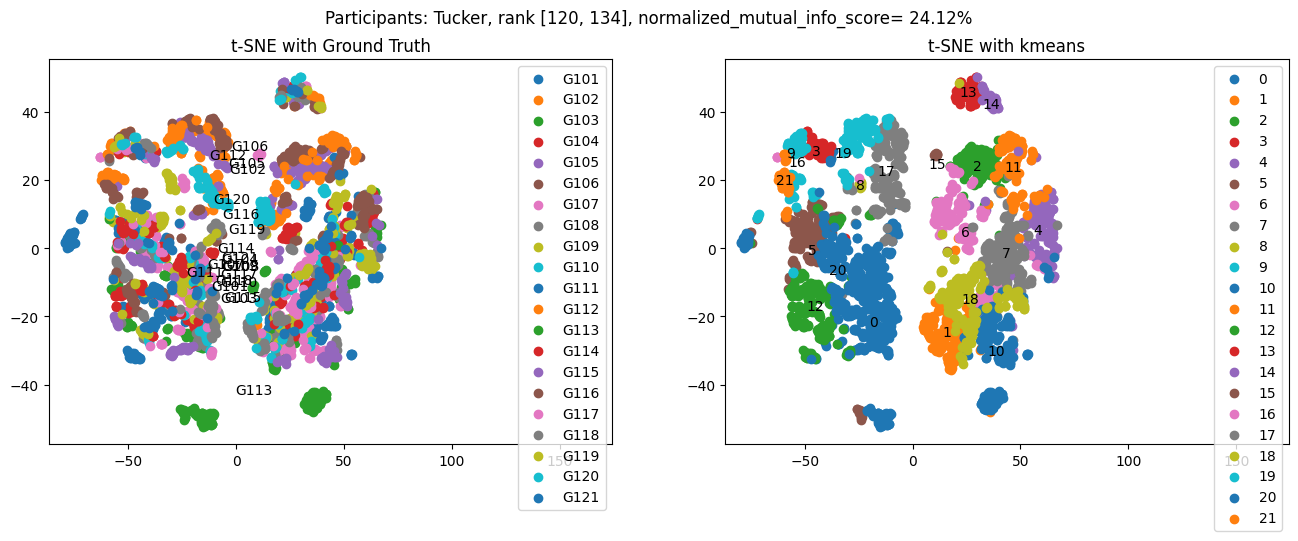

In [89]:
show_repr_2d(z_t, [sub_list, kmeans.labels_], second_subtitle="kmeans", )
acc = normalized_mutual_info_score(kmeans_hands.labels_,sub_list)
plt.gcf().suptitle(f'Participants: Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

Text(0.5, 0.98, 'Participants: Tucker, rank [120, 134], normalized_mutual_info_score= 24.12%')

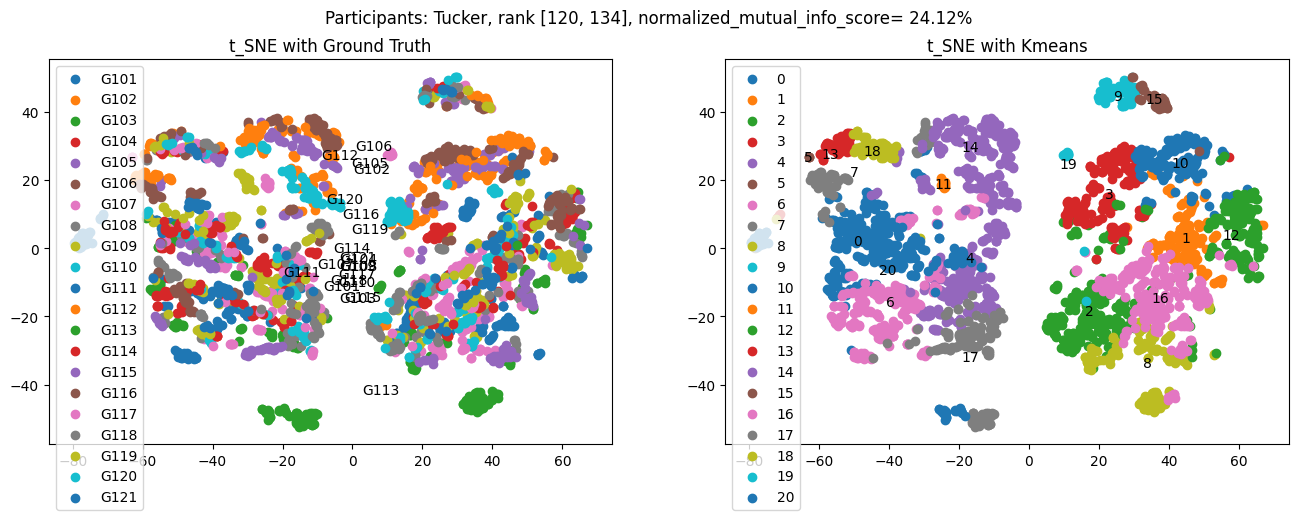

In [50]:
# # subjects

# # plt.figure(figsize=[8, 5])
# labels_order = [sub_list, kmeans_hands.labels_]
# fig, axs = plt.subplots(1, 2, figsize=[16, 5])

# z = z_t
# for j, (ax, labels) in enumerate(zip(axs, labels_order)):
    
#     for i, sub in enumerate(total_subjects): 
#         if j == 0:
#             title = "t_SNE with Ground Truth"
#             compare_value = sub
#             legend_label =  str(compare_value)
#             mask = np.where(np.array(labels) == compare_value)
#         elif j == 1:
#             title = "t_SNE with Kmeans"
#             compare_value = i
#             legend_label =  str(compare_value)
#             mask = np.where(np.array(labels) == compare_value) 
        
#         ax.scatter(z[mask,0], z[mask, 1], label=legend_label)
#         mean_ = z[mask].mean(axis=0)
#         tx = ax.text(mean_[0], mean_[1], legend_label, ha='center', va='center')
        
#     ax.set_title(title)  
#     ax.legend()

# acc = normalized_mutual_info_score(kmeans_hands.labels_,sub_list)
# plt.gcf().suptitle(f'Participants: Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

### Tucker left and right

In [90]:
left_hand = np.array([0, 2, 4, 5, 7, 9, 11, 13, 15, 17, 19])
right_hand = np.arange(22)[np.isin(np.arange(22), left_hand, invert=True)]

In [91]:
left_mask = np.isin(labels_list, left_hand)
data_tensor_left, labels_list_left, sub_list_left = data_tensor[left_mask], np.array(labels_list)[left_mask], np.array(sub_list)[left_mask]

right_mask = np.isin(labels_list, right_hand)
data_tensor_right, labels_list_right, sub_list_right = data_tensor[right_mask], np.array(labels_list)[right_mask], np.array(sub_list)[right_mask]

In [92]:
# left

core_l, factors_l = tucker_decompose(data_tensor_left, (44, 48, 52))


Tucker decomposition with rank: (44, 48, 52). tensor shape: (1388, 120, 134)


In [93]:
rank = [120, 134]
core_l, factors_l = partial_tucker(data_tensor_left, [1, 2], rank=rank, n_iter_max=1000)

In [94]:
core_l.shape

(1388, 120, 134)

In [95]:
U_l = core_l.reshape(core_l.shape[0], -1)

In [96]:
core_l.size

22319040

In [98]:
# TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123, learning_rate='auto', init='pca', n_jobs=32)
z_l = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1388 samples in 0.017s...
[t-SNE] Computed neighbors for 1388 samples in 0.811s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1388
[t-SNE] Computed conditional probabilities for sample 1388 / 1388
[t-SNE] Mean sigma: 1.955903


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.626709
[t-SNE] KL divergence after 1000 iterations: 0.891751


In [125]:
# Clustering:
X = U_l
n_clusters = len(left_hand)
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(X)


KMeans(n_clusters=11, random_state=0)

11 unique labels were formed
11 unique labels were formed


Text(0.5, 0.98, 'Left Hand, Tucker, rank [120, 134], normalized_mutual_info_score= 22.29%')

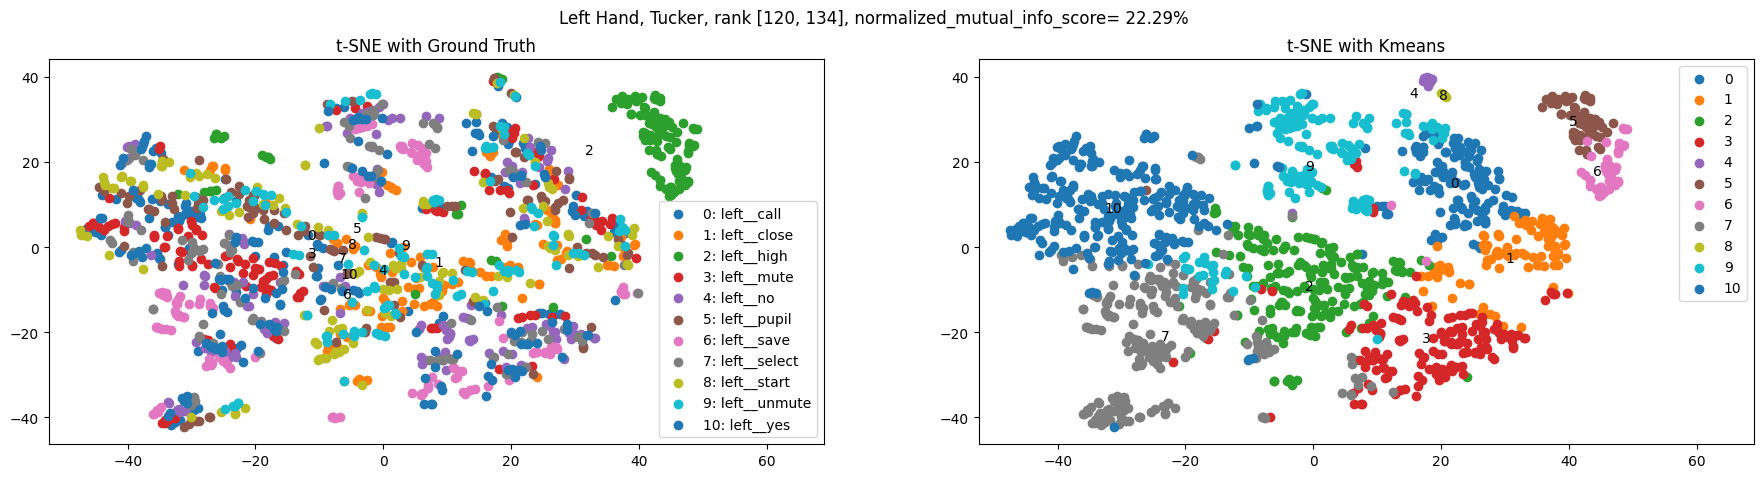

In [126]:
show_repr_2d(z_l, [form_label_values(labels_list_left, label_dict), kmeans.labels_], show_nums=True, second_subtitle='Kmeans', legend_space=15)
acc = normalized_mutual_info_score(kmeans.labels_,labels_list_left)
plt.gcf().suptitle(f'Left Hand, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

21 unique labels were formed
21 unique labels were formed
21 unique labels were formed


Text(0.5, 0.98, 'Left Hand Subjects, Tucker, rank [120, 134], normalized_mutual_info_score= 35.97%')

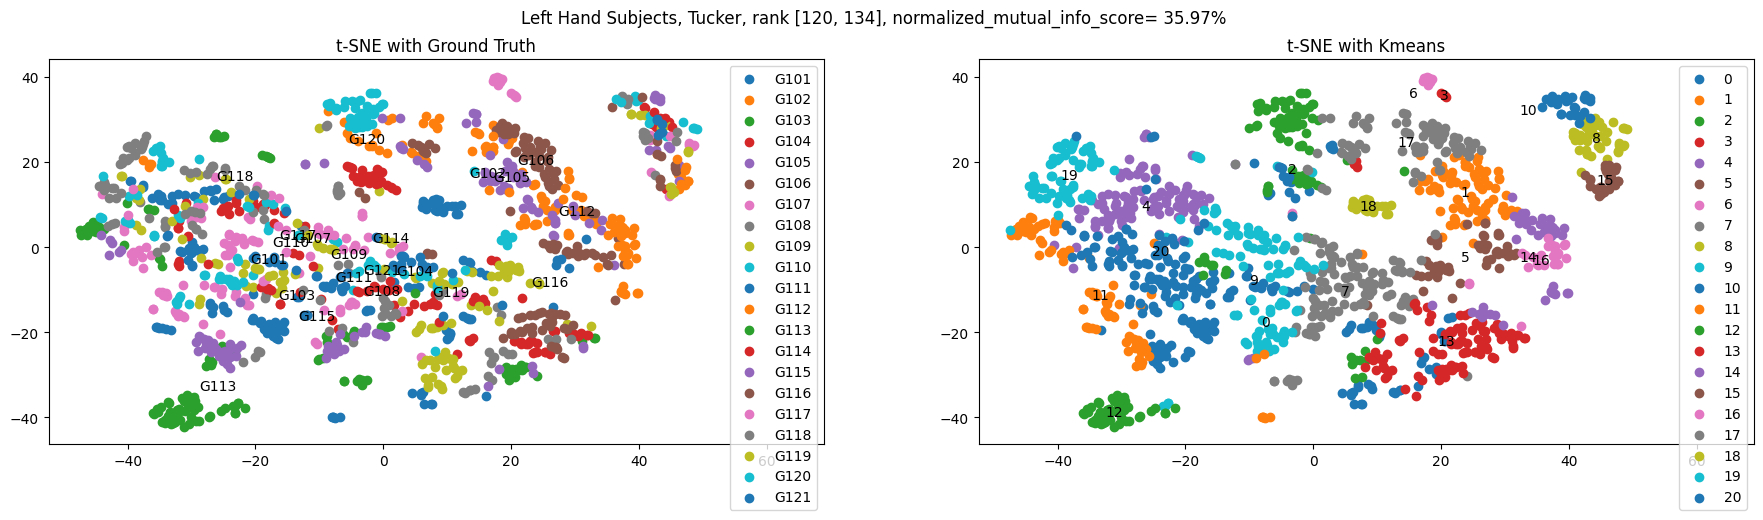

In [124]:
# subjects
# Clustering:

X = U_l
n_clusters = len(form_unique_labels(sub_list_left))
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(X)

show_repr_2d(z_l, [sub_list_left, kmeans.labels_], show_nums=False, second_subtitle='Kmeans', legend_space=15)
acc = normalized_mutual_info_score(kmeans.labels_,sub_list_left)
plt.gcf().suptitle(f'Left Hand Subjects, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

2 unique labels were formed
2 unique labels were formed
2 unique labels were formed


Text(0.5, 0.98, 'Left Hand Gender, Tucker, rank [120, 134], normalized_mutual_info_score= 2.99%')

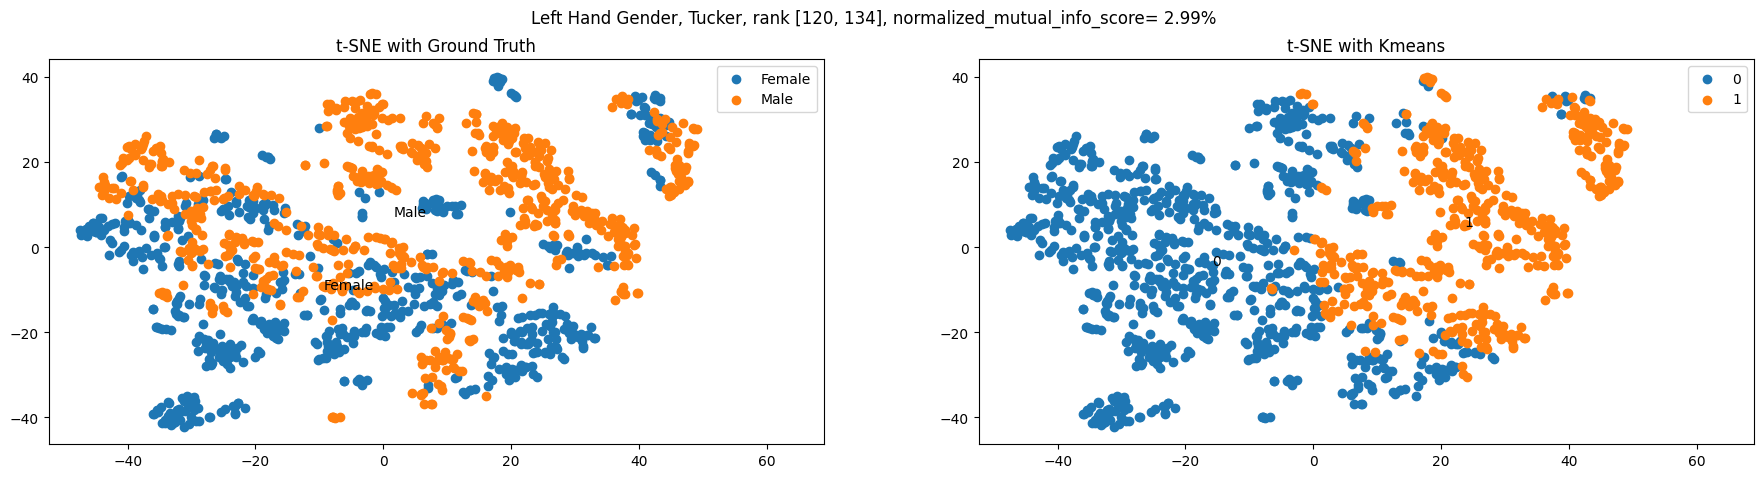

In [138]:
# gender

# gender
gender_dict = {}
with open('backup/gender.txt', 'r') as f:
    for line in f.readlines():
        sub, gender = line.strip().split()
        gender_dict[sub] = gender
gender_list = form_label_values(sub_list_left, gender_dict) 
# Clustering:
X = U_l
n_clusters = len(form_unique_labels(gender_list))
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(X)

show_repr_2d(z_l, [gender_list, kmeans.labels_], show_nums=False, second_subtitle='Kmeans', legend_space=15)
acc = normalized_mutual_info_score(kmeans.labels_,gender_list)
plt.gcf().suptitle(f'Left Hand Gender, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

In [162]:
# gender
z_, sub_list_, U_, hand = z_l, sub_list_left, U_l, 'Left'

gender_dict = {}
with open('backup/gender.txt', 'r') as f:
    for line in f.readlines():
        sub, gender = line.strip().split()
        gender_dict[sub] = gender
gender_list = form_label_values(sub_list_, gender_dict) 

In [163]:
from sklearn.cluster import  DBSCAN

X = U_
cluster_name = 'DBSCAN'
n_clusters = len(form_unique_labels(gender_list))

cluster_model = DBSCAN(min_samples=6)
cluster_model.fit(X)
print(form_unique_labels(cluster_model.labels_))

2 unique labels were formed
1 unique labels were formed
[-1]


In [164]:

X = U_
cluster_name = 'AggClust'
n_clusters = len(form_unique_labels(gender_list))

cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
cluster_model.fit(X)

2 unique labels were formed


AgglomerativeClustering()

In [166]:
X = U_
cluster_name = 'kmeans'
n_clusters = len(form_unique_labels(gender_list))

cluster_model = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
cluster_model.fit(X)

2 unique labels were formed


KMeans(n_clusters=2, random_state=0)

2 unique labels were formed
2 unique labels were formed


Text(0.5, 0.98, 'Left hand gender, Tucker, rank [120, 134], normalized_mutual_info_score= 2.99%')

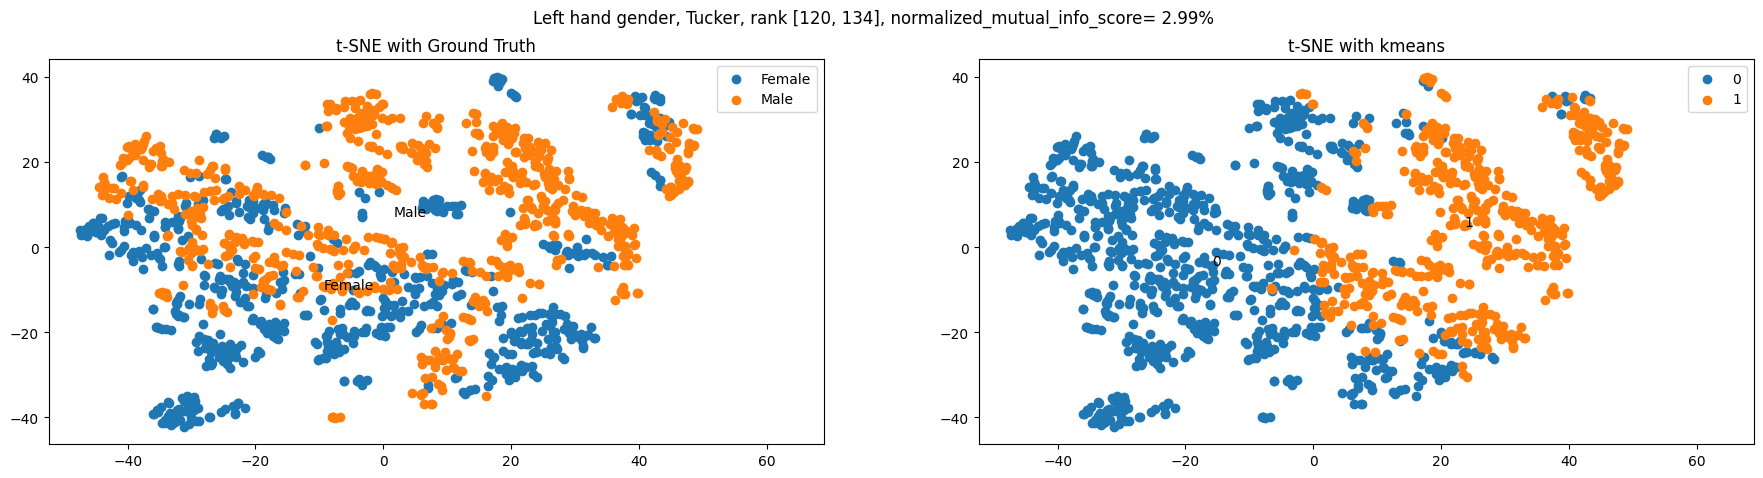

In [167]:
show_repr_2d(z_, [gender_list, cluster_model.labels_], show_nums=False, second_subtitle=cluster_name, legend_space=15)
acc = normalized_mutual_info_score(cluster_model.labels_,gender_list)
plt.gcf().suptitle(f'{hand} hand gender, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

In [184]:
# Main hand
z_, sub_list_, U_, hand = z_l, sub_list_left, U_l, 'Left'

parameter_dict = {}
with open('backup/main_hand.txt', 'r') as f:
    for line in f.readlines():
        sub, parameter = line.strip().split()
        parameter_dict[sub] = parameter
parameter_list = form_label_values(sub_list_, parameter_dict) 

In [ ]:
from sklearn.cluster import  DBSCAN

X = U_
cluster_name = 'DBSCAN'
n_clusters = len(form_unique_labels(parameter_list))

cluster_model = DBSCAN(min_samples=6)
cluster_model.fit(X)
print(form_unique_labels(cluster_model.labels_))

2 unique labels were formed
1 unique labels were formed
[-1]


In [185]:

X = U_
cluster_name = 'AggClust'
n_clusters = len(form_unique_labels(parameter_list))

cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
cluster_model.fit(X)

2 unique labels were formed


AgglomerativeClustering()

In [180]:
X = U_
cluster_name = 'kmeans'
n_clusters = len(form_unique_labels(parameter_list))

cluster_model = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
cluster_model.fit(X)

2 unique labels were formed


KMeans(n_clusters=2, random_state=0)

2 unique labels were formed
2 unique labels were formed


Text(0.5, 0.98, 'Left hand main_hand, Tucker, rank [120, 134], normalized_mutual_info_score= 1.94%')

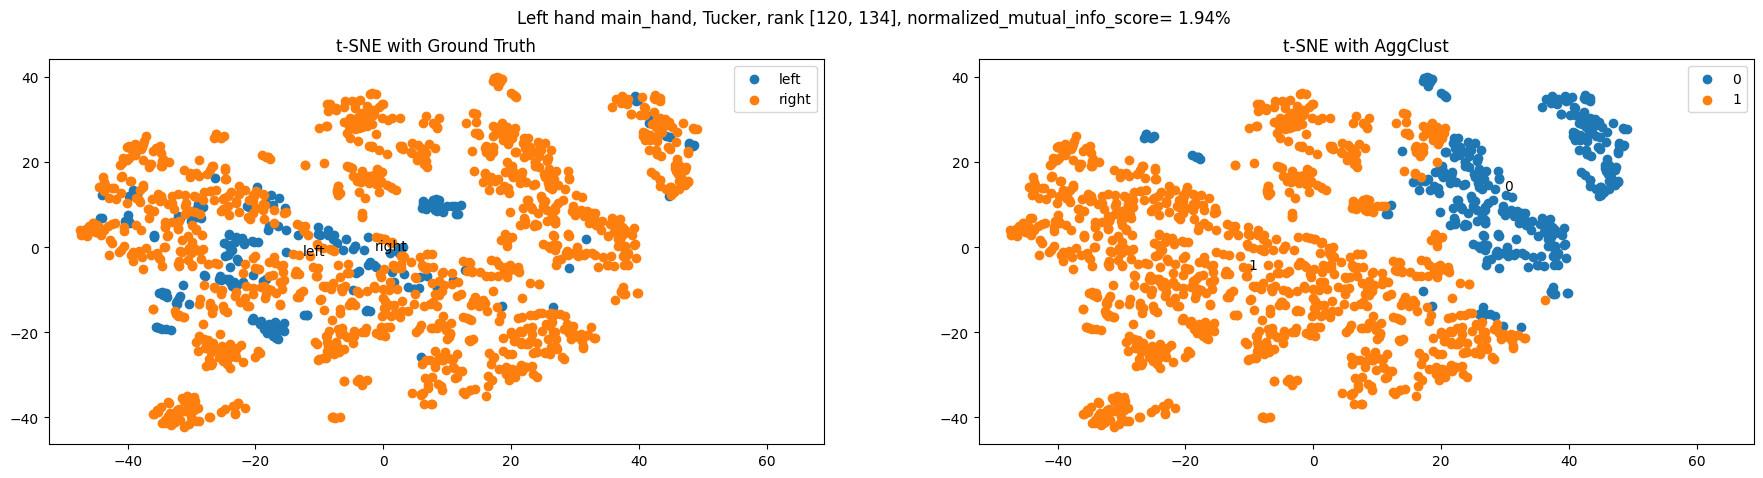

In [186]:
show_repr_2d(z_, [parameter_list, cluster_model.labels_], show_nums=False, second_subtitle=cluster_name, legend_space=15)
acc = normalized_mutual_info_score(cluster_model.labels_,parameter_list)
plt.gcf().suptitle(f'{hand} hand main_hand, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

In [114]:
# right
# right

# core_r, factors_r = tucker_decompose(data_tensor_right, (44, 48, 52))

rank = [120, 134]
core_r, factors_r = partial_tucker(data_tensor_right, [1, 2], rank=rank, n_iter_max=1000)
print(core_r.shape)
U_r = core_r.reshape(core_r.shape[0], -1)
core_r.size

(1410, 120, 134)


22672800

In [118]:

# TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123, learning_rate='auto', init='pca', n_jobs=32)
z_r = tsne.fit_transform(X)
z_r.shape


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1410 samples in 0.015s...
[t-SNE] Computed neighbors for 1410 samples in 0.744s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1410
[t-SNE] Computed conditional probabilities for sample 1410 / 1410
[t-SNE] Mean sigma: 1.798381


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.982414
[t-SNE] KL divergence after 1000 iterations: 0.825048


(1410, 2)

11 unique labels were formed
11 unique labels were formed


Text(0.5, 0.98, 'Right Hand, Tucker, rank [120, 134], normalized_mutual_info_score= 22.62%')

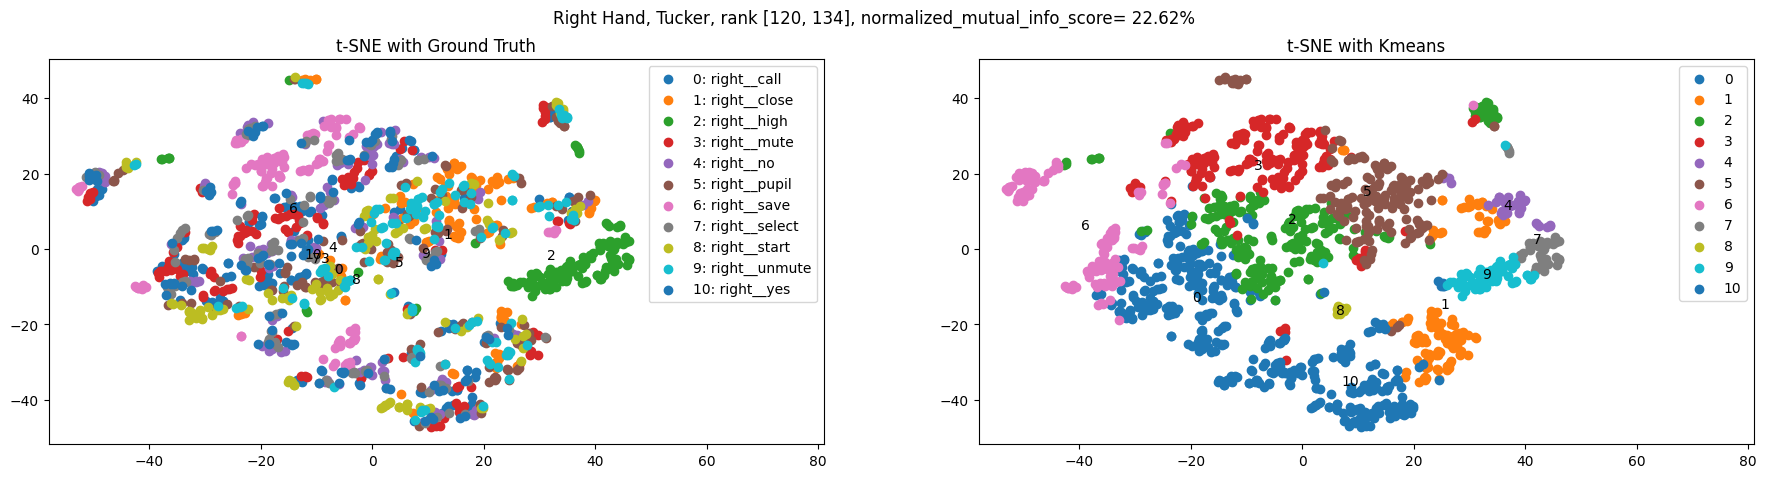

In [130]:

# Clustering:
X = U_r
n_clusters = len(right_hand)
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(X)

show_repr_2d(z_r, [form_label_values(labels_list_right, label_dict), kmeans.labels_], show_nums=True, second_subtitle='Kmeans', legend_space=30)
acc = normalized_mutual_info_score(kmeans.labels_,labels_list_right)
plt.gcf().suptitle(f'Right Hand, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')


In [122]:
# show_2d_representation(z_r, [labels_list_right, kmeans.labels_], label_dict, second_subtitle='Kmeans')
# acc = normalized_mutual_info_score(kmeans.labels_,labels_list_right)
# plt.gcf().suptitle(f'Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

21 unique labels were formed
21 unique labels were formed
21 unique labels were formed


Text(0.5, 0.98, 'Right Hand Subjects, Tucker, rank [120, 134], normalized_mutual_info_score= 37.50%')

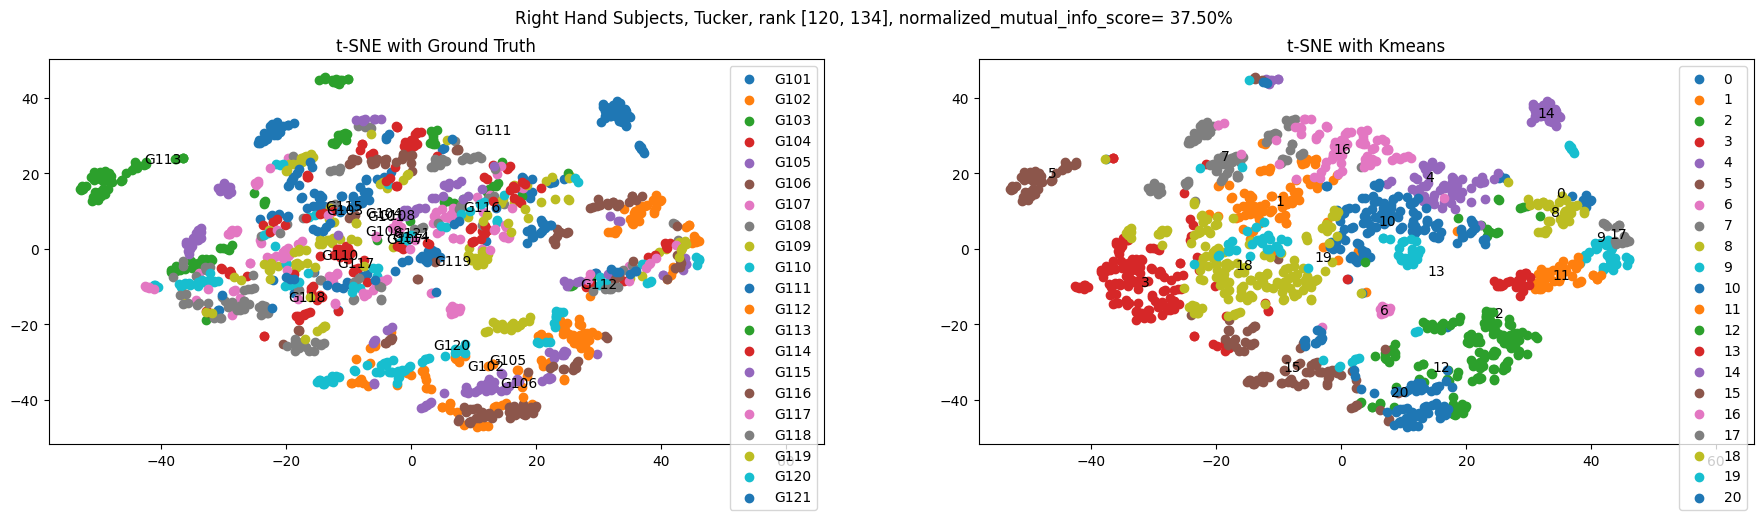

In [129]:
# subjects
# Clustering:
X = U_r
n_clusters = len(form_unique_labels(sub_list_right))
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(X)

show_repr_2d(z_r, [sub_list_right, kmeans.labels_], show_nums=False, second_subtitle='Kmeans', legend_space=15)
acc = normalized_mutual_info_score(kmeans.labels_, sub_list_right)
plt.gcf().suptitle(f'Right Hand Subjects, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')


In [168]:
# gender
z_, sub_list_, U_, hand = z_r, sub_list_right, U_r, 'Right'

gender_dict = {}
with open('backup/gender.txt', 'r') as f:
    for line in f.readlines():
        sub, gender = line.strip().split()
        gender_dict[sub] = gender
gender_list = form_label_values(sub_list_, gender_dict) 

In [159]:
from sklearn.cluster import  DBSCAN

X = U_
cluster_name = 'DBSCAN'
n_clusters = len(form_unique_labels(gender_list))

cluster_model = DBSCAN(min_samples=6)
cluster_model.fit(X)
print(form_unique_labels(cluster_model.labels_))

2 unique labels were formed
1 unique labels were formed
[-1]


In [160]:

X = U_
cluster_name = 'AggClust'
n_clusters = len(form_unique_labels(gender_list))

cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
cluster_model.fit(X)

2 unique labels were formed


AgglomerativeClustering()

In [169]:
X = U_
cluster_name = 'kmeans'
n_clusters = len(form_unique_labels(gender_list))

cluster_model = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
cluster_model.fit(X)

2 unique labels were formed


KMeans(n_clusters=2, random_state=0)

2 unique labels were formed
2 unique labels were formed


Text(0.5, 0.98, 'Right hand gender, Tucker, rank [120, 134], normalized_mutual_info_score= 4.97%')

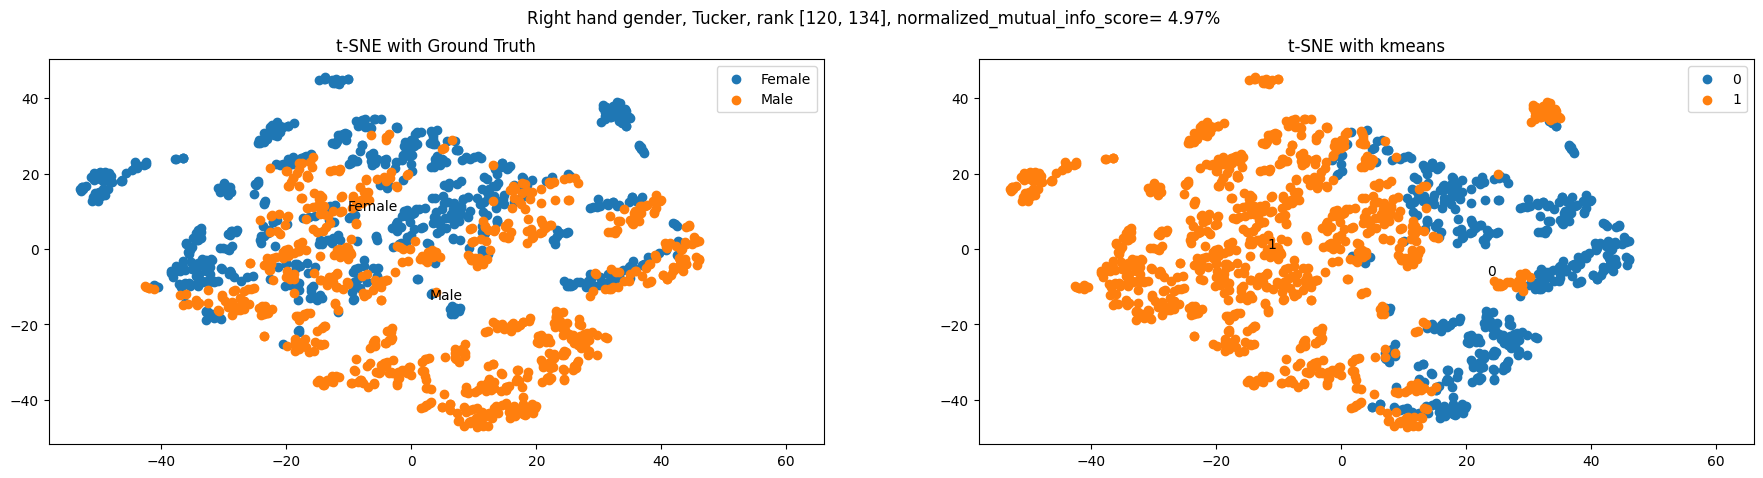

In [170]:
show_repr_2d(z_, [gender_list, cluster_model.labels_], show_nums=False, second_subtitle=cluster_name, legend_space=15)
acc = normalized_mutual_info_score(cluster_model.labels_,gender_list)
plt.gcf().suptitle(f'{hand} hand gender, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

In [173]:
# Main hand
z_, sub_list_, U_, hand = z_r, sub_list_right, U_r, 'Right'

parameter_dict = {}
with open('backup/main_hand.txt', 'r') as f:
    for line in f.readlines():
        sub, parameter = line.strip().split()
        parameter_dict[sub] = parameter
parameter_list = form_label_values(sub_list_, parameter_dict) 

In [174]:
from sklearn.cluster import  DBSCAN

X = U_
cluster_name = 'DBSCAN'
n_clusters = len(form_unique_labels(parameter_list))

cluster_model = DBSCAN(min_samples=6)
cluster_model.fit(X)
print(form_unique_labels(cluster_model.labels_))

2 unique labels were formed
1 unique labels were formed
[-1]


In [175]:

X = U_
cluster_name = 'AggClust'
n_clusters = len(form_unique_labels(parameter_list))

cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
cluster_model.fit(X)

2 unique labels were formed


AgglomerativeClustering()

In [177]:
X = U_
cluster_name = 'kmeans'
n_clusters = len(form_unique_labels(parameter_list))

cluster_model = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
cluster_model.fit(X)

2 unique labels were formed


KMeans(n_clusters=2, random_state=0)

2 unique labels were formed
2 unique labels were formed


Text(0.5, 0.98, 'Right hand main_hand, Tucker, rank [120, 134], normalized_mutual_info_score= 1.52%')

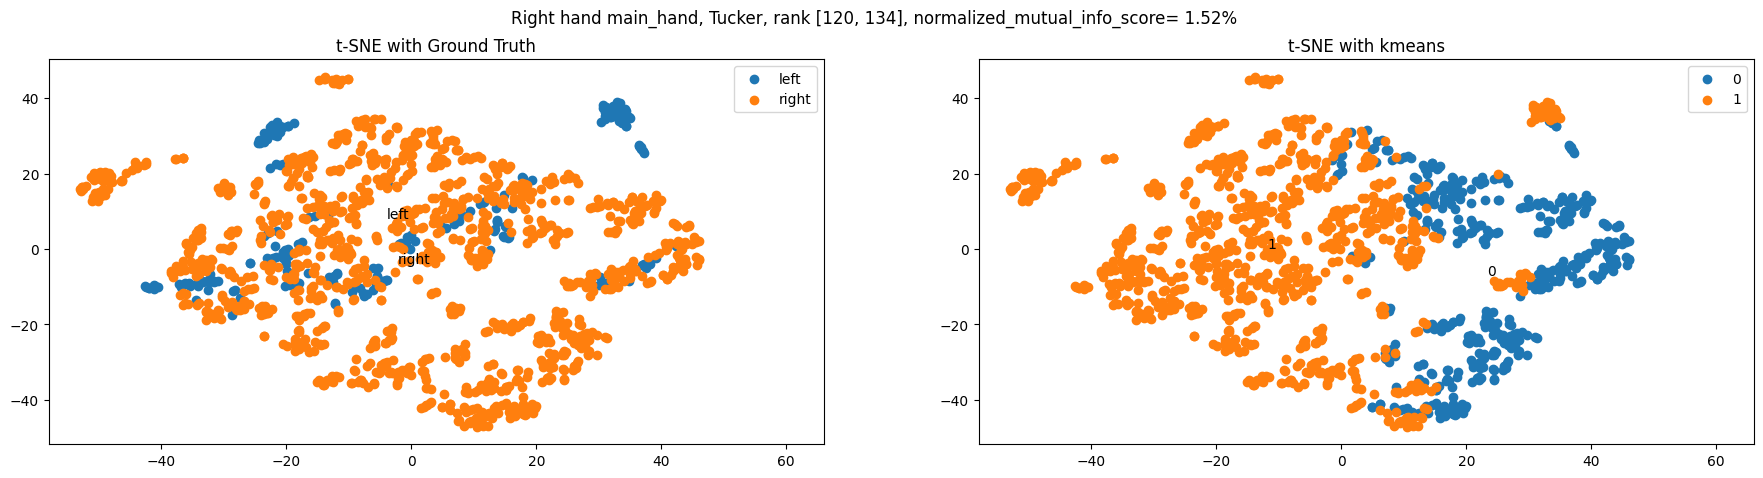

In [178]:
show_repr_2d(z_, [parameter_list, cluster_model.labels_], show_nums=False, second_subtitle=cluster_name, legend_space=15)
acc = normalized_mutual_info_score(cluster_model.labels_,parameter_list)
plt.gcf().suptitle(f'{hand} hand main_hand, Tucker, rank {rank}, normalized_mutual_info_score={acc*100: .2f}%')

### Checking

In [131]:
labels_list[0], labels_list[397]

(0, 4)

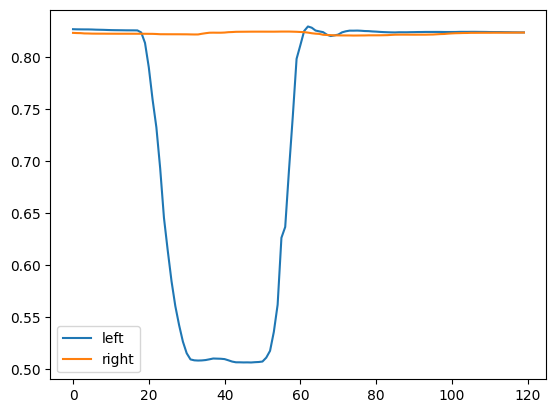

In [149]:
trial = 0
plt.plot(data_tensor[trial, :, 15*2+1], label='left')
plt.plot(data_tensor[trial, :, 16*2+1], label='right')
plt.legend()

In [133]:
label_dict

{0: 'left__call',
 1: 'right__call',
 2: 'left__close',
 3: 'right__close',
 4: 'left__high',
 5: 'left__mute',
 6: 'right__mute',
 7: 'left__no',
 8: 'right__no',
 9: 'left__pupil',
 10: 'right__pupil',
 11: 'left__save',
 12: 'right__save',
 13: 'left__select',
 14: 'right__select',
 15: 'left__start',
 16: 'right__start',
 17: 'left__unmute',
 18: 'right__unmute',
 19: 'left__yes',
 20: 'right__yes',
 21: 'right__high'}

In [130]:
# data_tensor[0]

In [152]:
mask = np.where(np.isin(np.array(labels), np.array(left_hand), invert=0))
a = z[mask,1]
a.min()

-7.525809

In [153]:
np.where(a == a.min())

(array([0]), array([354]))

#### code

In [9]:
# Tucker with HOSVD
t = data_tensor
tt = data_tensor_test
rank = [120, 134]
core_tucker, factors_tucker = partial_tucker(t, [1, 2], rank=rank, n_iter_max=1000)

# rank = [8, 60, 20]
# core_tucker, factors_tucker = tucker(t, rank=rank)


KeyboardInterrupt: 

In [11]:
# t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
# print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

Tucker: Rank: [120, 134], rel_error:  0.00000 ; norm origin: 5982.350322460424 ; norm recovered: 5982.350322460414


In [140]:
# # t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
# t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
# print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

In [12]:
# factors = factors_tucker
# factors = [None] + factors

# tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=[1, 2])
# tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=[1, 2])

# # core = core_tucker
# # tensor_tucker = mode_dot(core, factors[0], mode=0)

In [8]:
# def get_tucker_tensors(data_tensor, data_tensor_test, rank=None, n_iter_max=1000, verbose=1):
#     t = data_tensor
#     tt = data_tensor_test
    
#     if rank is None:
#         rank = data_tensor.shape[1:]
        
#     modes = [i for i in range(len(data_tensor.shape))]
#     modes = modes[1:]
#     core_tucker, factors_tucker = partial_tucker(t, modes, rank=rank, n_iter_max=n_iter_max)
    
#     if verbose > 0:
#         t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
#         print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")
            
#     factors = factors_tucker
#     factors = [None] + factors
#     tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=modes)
#     tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=modes)
        
#     return tensor_tucker, tensor_tucker_test
        

#### Selecting ranks

In [130]:
t_uf0 = tl.unfold(t, mode=0)
t_uf1 = tl.unfold(t, mode=1)
t_uf2 = tl.unfold(t, mode=2)

In [131]:
# u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
u_1, s_1, v_1 = tl.partial_svd(t_uf1, 120)
u_2, s_2, v_2 = tl.partial_svd(t_uf2, 134)

norm_t = tl.norm(t)

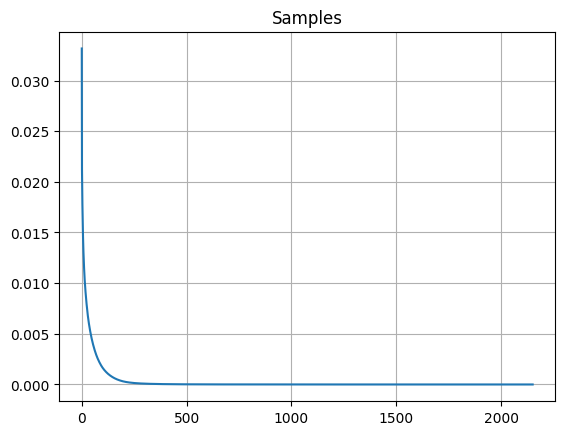

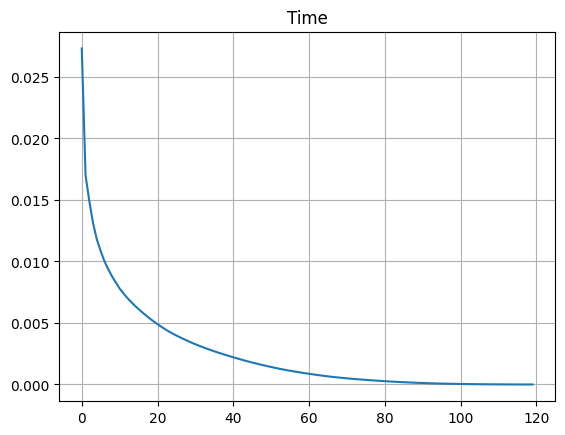

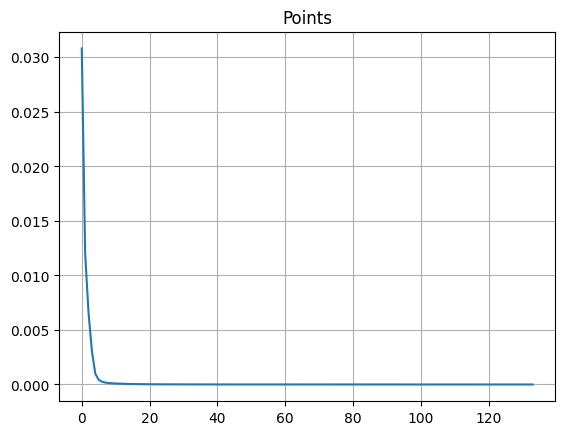

In [157]:
show_decomposition_error(s_0, norm_t,'Samples',)
show_decomposition_error(s_1, norm_t,'Time',)
show_decomposition_error(s_2, norm_t,'Points',)


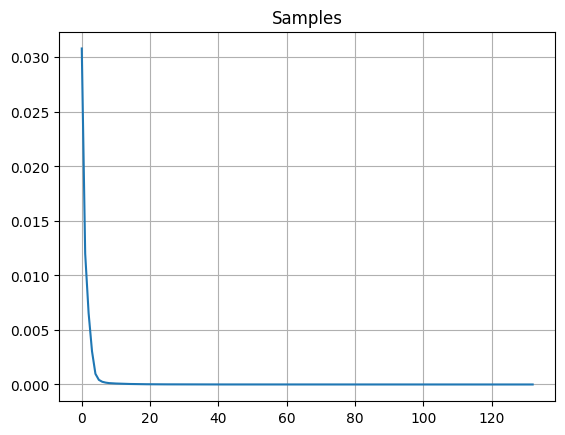

In [134]:
show_decomposition_error(s_2, norm_t,'Samples', d_step=1)